In [26]:
import sys
sys.path.append('/home/sarrah/clean/CLEAN')

In [91]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 7.6 MB/s eta 0:00:00ta 0:00:01


In [31]:
from CLEAN.infer import infer_maxsep
from CLEAN.utils import * 
from app.src.CLEAN.model import LayerNormNet
from app.src.CLEAN.distance_map import *
from app.src.CLEAN.evaluate import *
import subprocess
import pandas as pd

In [4]:
def retrieve_esm1b_embedding(fasta_name):
    esm_script = "/home/sarrah/clean/CLEAN/app/esm/scripts/extract.py"
    esm_out = "/home/sarrah/clean/CLEAN/app/data/esm_data"
    esm_type = "esm1b_t33_650M_UR50S"
    fasta_name = "/home/sarrah/clean/CLEAN/app/testing/data/" + fasta_name + ".fasta"
    command = ["python", esm_script, esm_type, 
              fasta_name, esm_out, "--include", "mean"]
    subprocess.run(command)

#Note I deleted Hyer-7 because it had 47 in it and this one >MaybeCbAgo and I deleted the first 2 rows


In [8]:
retrieve_esm1b_embedding('sarrahtestset')

Transferred model to GPU
Read /home/sarrah/clean/CLEAN/app/testing/data/sarrahtestset.fasta with 38 sequences
Processing 1 of 10 batches (10 sequences)
Processing 2 of 10 batches (6 sequences)
Processing 3 of 10 batches (6 sequences)
Processing 4 of 10 batches (4 sequences)
Processing 5 of 10 batches (3 sequences)
Processing 6 of 10 batches (3 sequences)
Processing 7 of 10 batches (2 sequences)
Processing 8 of 10 batches (2 sequences)
Processing 9 of 10 batches (1 sequences)
Processing 10 of 10 batches (1 sequences)


In [11]:
#Generate CSV file for fasta file
def fasta_to_csv(fasta_name):
    csvfile = open('/home/sarrah/clean/CLEAN/app/testing/data/' + fasta_name +'.csv', 'w', newline='')
    csvwriter = csv.writer(csvfile, delimiter = '\t')
    csvwriter.writerow(['Entry', 'EC number', 'Sequence'])
    fastafile = open('./data/' + fasta_name +'.fasta', 'r')
    for i in fastafile.readlines():
        if i[0] == '>':
            csvwriter.writerow([i.strip()[1:], ' ', ' '])

In [12]:
fasta_to_csv('sarrahtestset')

In [13]:
#pretend I have a training csv file for inference    
train_data = "/home/sarrah/clean/CLEAN/app/data/split100"
test_data = "/home/sarrah/clean/CLEAN/app/testing/data/sarrahtestset"


In [16]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
dtype = torch.float32
id_ec_train, ec_id_dict_train = get_ec_id_dict(train_data  + '.csv')
id_ec_test, _ = get_ec_id_dict(test_data + '.csv')

In [28]:
model = LayerNormNet(512, 128, device, dtype)
checkpoint = torch.load('/home/sarrah/clean/CLEAN/app/data/pretrained/split100.pth', map_location=device)
model.load_state_dict(checkpoint)
model.eval()
emb_train = torch.load('/home/sarrah/clean/CLEAN/app/data/pretrained/100.pt', map_location=device)

In [36]:
def load_esm(lookup):
    esm = format_esm(torch.load('/home/sarrah/clean/CLEAN/app/data/esm_data/' + lookup + '.pt'))
    return esm.unsqueeze(0)

def model_embedding_test_new(id_ec_test, model, device, dtype):
    ids_for_query = list(id_ec_test.keys())
    esm_to_cat = [load_esm(id) for id in ids_for_query]
    esm_emb = torch.cat(esm_to_cat).to(device=device, dtype=dtype)
    model_emb = model(esm_emb)
    return model_emb

In [39]:
emb_test = model_embedding_test_new(id_ec_test, model, device, dtype)
eval_dist = get_dist_map_test(emb_train, emb_test, ec_id_dict_train, id_ec_test, device, dtype)
seed_everything()
eval_df = pd.DataFrame.from_dict(eval_dist)
out_filename = test_data
write_max_sep_choices(eval_df, out_filename, gmm=None)


The embedding sizes for train and test: torch.Size([241025, 128]) torch.Size([36, 128])


  0%|          | 0/5242 [00:00<?, ?it/s]

100%|██████████| 5242/5242 [00:00<00:00, 26952.22it/s]


Calculating eval distance map, between 36 test ids and 5242 train EC cluster centers


36it [00:00, 846.91it/s]


In [49]:
out_filename+'_maxsep.csv'

'/home/sarrah/clean/CLEAN/app/testing/data/sarrahtestset_maxsep.csv'

In [57]:
#probably need to find a better way to keep track of ordering - currently just tracking indexing in csv file
EC_clusters = {}
i = 0 
with open(out_filename+'_maxsep.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        # Process each row
        seq_id = row[0]
        first_EC = row[1].split('/')[0][3:].split('.')[0]
        
        if first_EC not in EC_clusters: 
            EC_clusters[first_EC] = {}
        EC_clusters[first_EC][seq_id] = i
        i += 1
        

In [68]:
EC_clusters['3']

{'PE': 0,
 'CBE': 1,
 'ABE': 2,
 'SaCas9': 3,
 'SpCas9': 4,
 'SpRY': 5,
 'Cas12i_chainA': 6,
 'Cas12f1': 7,
 'Cas12a_andgRNA': 8,
 'RfxCas13d_andgRNA_drosophilia': 9,
 'Fanzor_TDe': 10,
 'Fanzor_SCe_ORF9': 11,
 'Tnpb': 12,
 'Argonaute2_AGO2': 13,
 'SHtnsb': 23,
 'ShTnsC': 24,
 'ShCas12k': 26,
 'I-SceI': 28,
 'EcoRI': 30,
 'Alt_Control_26_5': 34}

In [58]:
EC_clusters

{'3': {'PE': 0,
  'CBE': 1,
  'ABE': 2,
  'SaCas9': 3,
  'SpCas9': 4,
  'SpRY': 5,
  'Cas12i_chainA': 6,
  'Cas12f1': 7,
  'Cas12a_andgRNA': 8,
  'RfxCas13d_andgRNA_drosophilia': 9,
  'Fanzor_TDe': 10,
  'Fanzor_SCe_ORF9': 11,
  'Tnpb': 12,
  'Argonaute2_AGO2': 13,
  'SHtnsb': 23,
  'ShTnsC': 24,
  'ShCas12k': 26,
  'I-SceI': 28,
  'EcoRI': 30,
  'Alt_Control_26_5': 34},
 '5': {'MpAgo_Doudna_Hydroxylatedguides': 14,
  'topoisomerase1': 31,
  'topoisomerase2': 32},
 '2': {'HYER_5': 15,
  'HYER_1': 16,
  'HYER_8': 17,
  'HYER_9': 18,
  'HYER_4': 19,
  'HYER_6': 20,
  'HYER_2': 21,
  'HYER_3': 22,
  'ShTniQ': 25,
  'FEN1': 27,
  'RecB': 29,
  'Control_EC_3_1_26_5': 33},
 '1': {'Control_EC_3_1_21_4': 35}}

In [60]:
emb_test

tensor([[-0.4264, -1.0834, -0.3555,  ..., -0.8255, -0.5581, -0.2003],
        [-0.5056, -0.3932,  0.3005,  ..., -0.9965, -0.4348,  0.0722],
        [-0.4781,  0.1035, -0.0432,  ..., -1.2257, -0.9903,  0.5119],
        ...,
        [ 0.5099,  0.0699,  0.8023,  ..., -0.5812, -0.9308,  0.2635],
        [-1.4947, -0.9820,  0.8851,  ..., -2.2404,  0.2944, -0.2779],
        [ 0.8548,  0.0071, -0.1131,  ..., -1.1010,  0.4221,  1.6963]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [81]:
EC_specific_embeddings = [emb_test[i] for i in EC_clusters['3'].values()]
EC_specific_embeddings_tensor = torch.stack(EC_specific_embeddings)

In [82]:
EC_specific_embeddings_tensor

tensor([[-0.4264, -1.0834, -0.3555,  ..., -0.8255, -0.5581, -0.2003],
        [-0.5056, -0.3932,  0.3005,  ..., -0.9965, -0.4348,  0.0722],
        [-0.4781,  0.1035, -0.0432,  ..., -1.2257, -0.9903,  0.5119],
        ...,
        [-0.7686, -0.3457,  0.6158,  ..., -1.2841, -0.2428,  0.5374],
        [-0.9204, -0.6575,  0.1511,  ..., -1.7431,  0.9128,  0.3040],
        [-1.4947, -0.9820,  0.8851,  ..., -2.2404,  0.2944, -0.2779]],
       device='cuda:0', grad_fn=<StackBackward0>)

In [84]:
for EC in EC_clusters: 
    print(EC)

3
5
2
1


In [88]:
intra_cluster_distances = {}
i=0
for EC in EC_clusters: 
    print(f'Round {i}')
    print(EC)
    #Select the embeddings and put them all into one tensor
    EC_specific_embeddings = [emb_test[i] for i in EC_clusters[EC].values()]
    EC_specific_embeddings_tensor = torch.stack(EC_specific_embeddings)

    EC_specific_embeddings_tensor = F.normalize(EC_specific_embeddings_tensor, dim=-1, p=2)
    distances = torch.cdist(EC_specific_embeddings_tensor, EC_specific_embeddings_tensor, p=2)
    intra_cluster_distances[EC] = distances
    i+=1

Round 0
3
Round 1
5
Round 2
2
Round 3
1


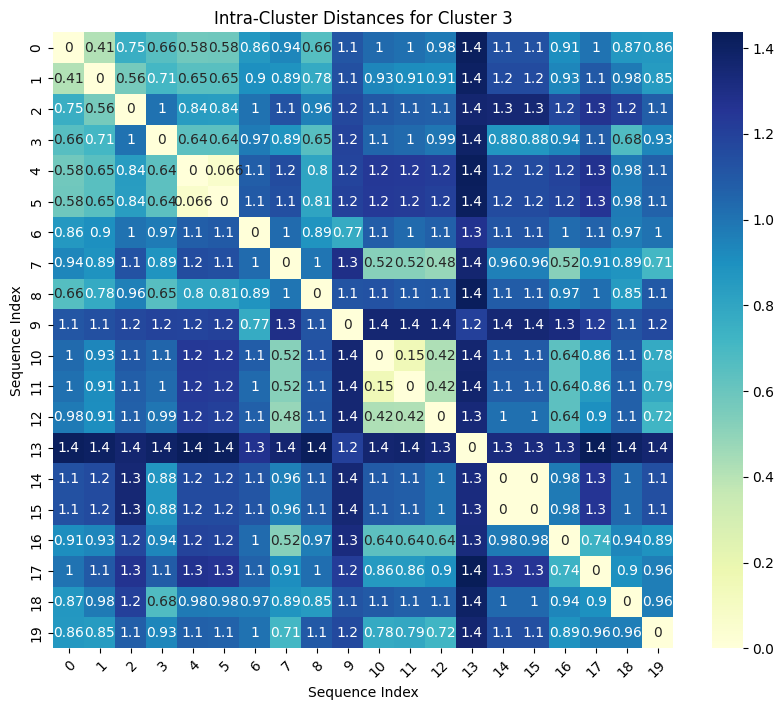

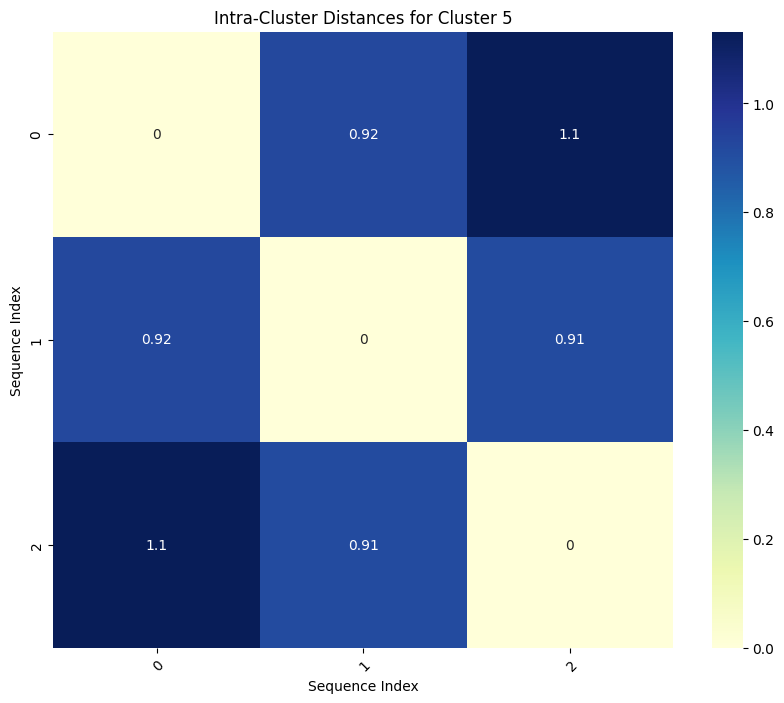

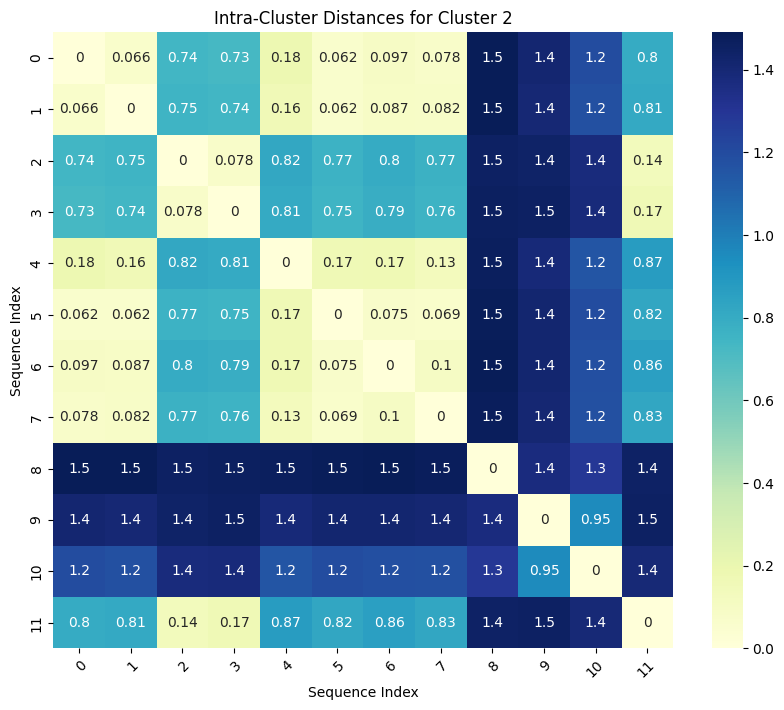

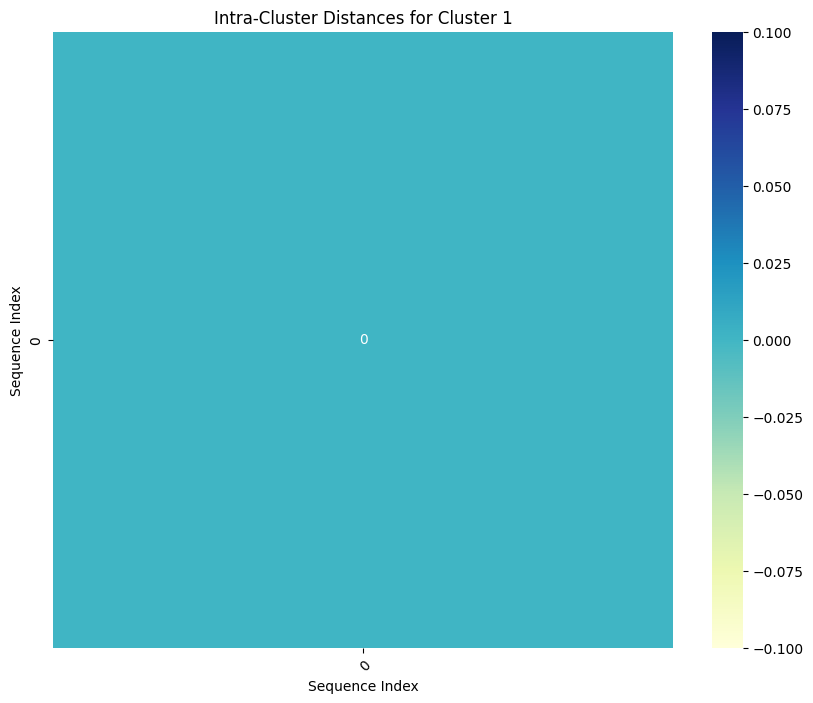

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming intra_cluster_distances is a dictionary where keys are cluster labels
# and values are the corresponding distance matrices

# Iterate over the dictionary to create a heatmap for each cluster
for cluster_label, distance_matrix in intra_cluster_distances.items():

    distance_matrix = distance_matrix.cpu().detach().numpy()
    # Create a heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(distance_matrix, annot=True, cmap="YlGnBu", ax=ax)
    
    # Add title and axis labels
    ax.set_title(f"Intra-Cluster Distances for Cluster {cluster_label}")
    ax.set_xlabel("Sequence Index")
    ax.set_ylabel("Sequence Index")
    
    # Rotate x-axis tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Show the heatmap
    plt.show()